#**Residual Network (ResNet)**
**ResNet (Residual Network)** is a deep learning architecture designed to address the problem of vanishing/exploding gradients in very deep neural networks.

***

This .ipynb file is about training a Residual Network (ResNet) model on the **CIFAR-10 dataset** using TensorFlow/Keras.

**Key Components:**

**Dataset**: The CIFAR-10 dataset is used (only the training dataset).

**Data Augmentation**: The code employs ImageDataGenerator for augmenting the images (rotation, shift, flip, etc.) to reduce overfitting.

**Model Architectur**e: The ResNet architecture is implemented with both identity blocks and non-identity blocks, which are key components of ResNet.

**Training**: The model is compiled, trained using the augmented dataset, and evaluated with training and validation sets.

### **Import Libraries**

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

### **Load and Preview Dataset**


In [2]:
# File will only take the training dataset and split it into training, validation and testing for practice purposes.
# Load the CIFAR-10 dataset (training data only)
(xdataset, ydataset), _ = cifar10.load_data()
print("Number of images:", len(xdataset))

Number of images: 50000


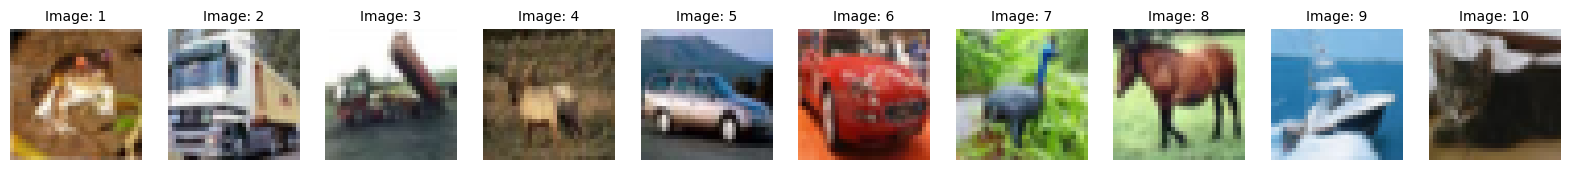

In [3]:
# Plot the first 10 images
plt.figure(figsize=(20, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)  # 1 row, 10 columns
    plt.imshow(xdataset[i])
    plt.axis('off')  # Turn off the axes
    plt.title(f"Image: {i+1}", fontsize=10)  # Add a simple title
plt.show()

## **Data Augmentation with ImageDataGenerator**

In [4]:
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Helps load batches as dataset with Image Augmentation
#Augmentaion (transforms dataset) -> prevents overfitting

# ImageDataGenerator for augmentation with validation split
traindata_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True,
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2  # Split 20% for validation
)

In [5]:
# Create batches for training and validation
train_batch = traindata_gen.flow(
    xdataset,
    y=ydataset,
    batch_size=128,
    subset='training'  # Specifies the training split
)

validation_batch = traindata_gen.flow(
    xdataset,
    y=ydataset,
    batch_size=128,
    subset='validation'  # Specifies the validation split
)

In [6]:
print(f"Training batches: {len(train_batch)}")
print(f"Validation batches: {len(validation_batch)}")

Training batches: 313
Validation batches: 79


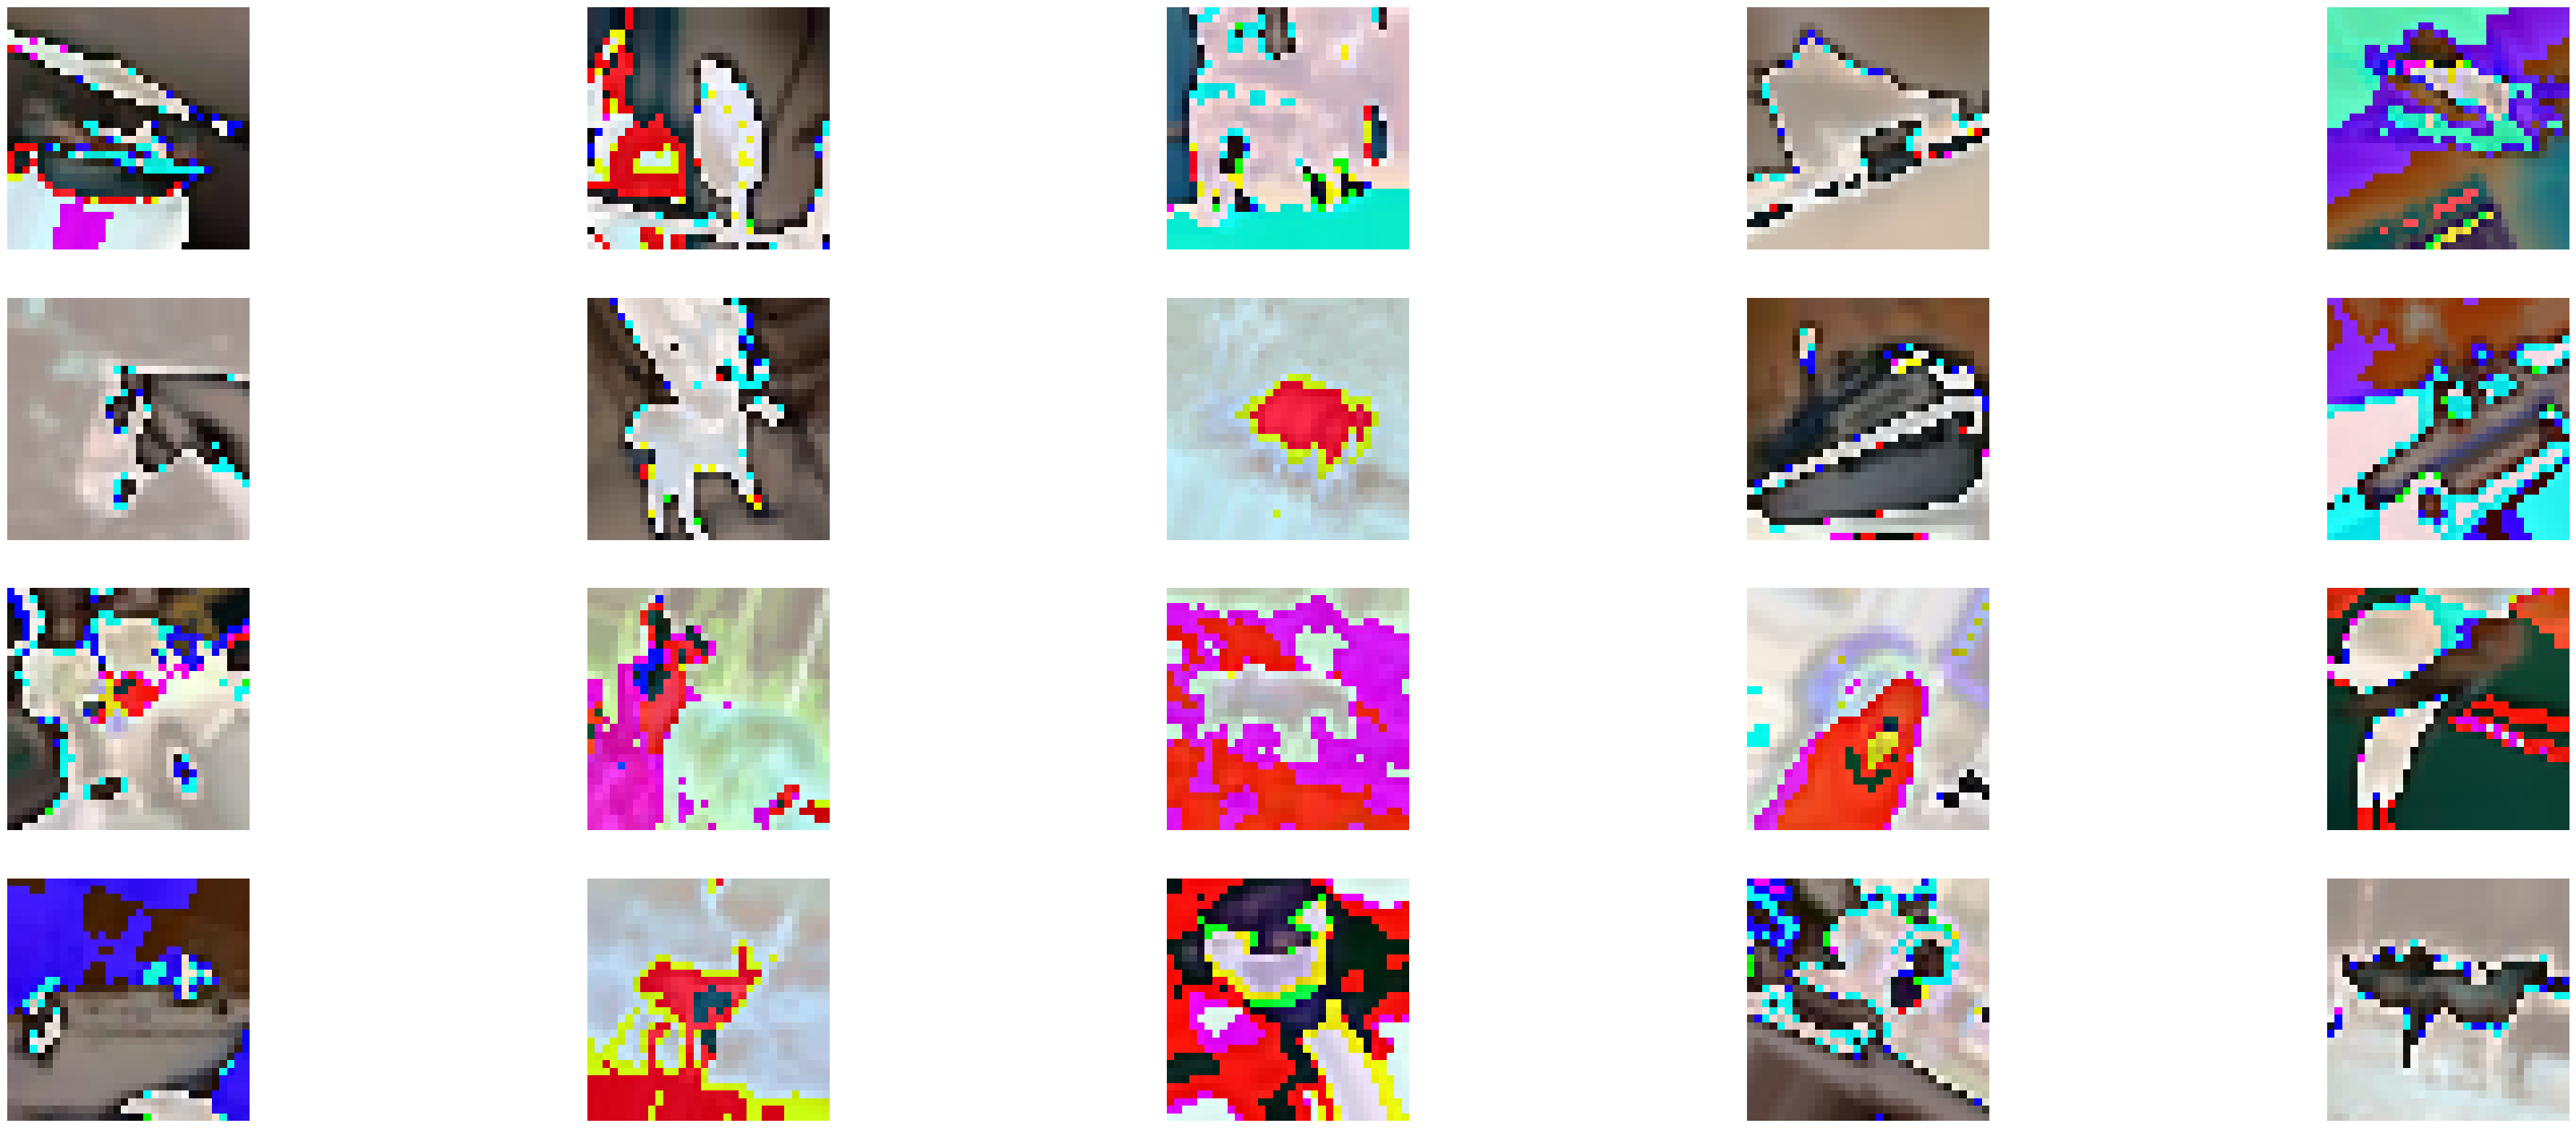

In [7]:
# Visualize Augmented Images
imgs, labels = next(train_batch)
plt.figure(figsize=(50, 20))
index = 0
for img, label in zip(imgs, labels):
    plt.subplot(4, 5, index + 1)  # 1 row, 10 columns
    plt.imshow(img.astype('uint8'))
    plt.axis('off')  # Turn off the axes
    plt.xlabel(label)
    index += 1
    if index == 20:
      break
plt.show()

#**Implementing ResNet**

In [8]:
# Implement Identity Block for ResNet
def identity_block(X, filters):
    f1, f2, f3 = filters
    X_shortcut = X

    # First component
    X = layers.Conv2D(filters=f1, kernel_size=(1, 1), strides=(1, 1), padding='same')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X)

    # Second component
    X = layers.Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X)

    # Third component
    X = layers.Conv2D(filters=f3, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = layers.BatchNormalization(axis=3)(X)

    # Add shortcut and apply ReLU
    print(X.shape, X_shortcut.shape)  # Debugging shapes
    X = layers.Add()([X, X_shortcut])
    X = layers.Activation('relu')(X)
    return X


In [9]:
# Implement Non-Identity Block for ResNet
def nonidentity_block(X, filters, s=2):
    f1, f2, f3 = filters
    X_shortcut = X

    # First component
    X = layers.Conv2D(filters=f1, kernel_size=(1, 1), strides=(s, s), padding='same')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X)

    # Second component
    X = layers.Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X)

    # Third component
    X = layers.Conv2D(filters=f3, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = layers.BatchNormalization(axis=3)(X)

    # Shortcut path
    X_shortcut = layers.Conv2D(filters=f3, kernel_size=(1, 1), strides=(s, s), padding='same')(X_shortcut)
    X_shortcut = layers.BatchNormalization(axis=3)(X_shortcut)

    # Add shortcut and apply ReLU
    print(X.shape, X_shortcut.shape)  # Debugging shapes
    X = layers.Add()([X, X_shortcut])
    X = layers.Activation('relu')(X)
    return X

##**Build ResNet Model Architecture**

In [10]:
def ResNet():
    # Input layer
    X_input = tf.keras.Input((32, 32, 3))

    # Initial convolution and max-pooling
    X = layers.ZeroPadding2D((3, 3))(X_input)
    X = layers.Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2))(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 1
    X = nonidentity_block(X, [64, 64, 256], s=1)
    X = identity_block(X, [64, 64, 256])
    X = identity_block(X, [64, 64, 256])

    # Stage 2
    X = nonidentity_block(X, [128, 128, 512], s=2)
    X = identity_block(X, [128, 128, 512])
    X = identity_block(X, [128, 128, 512])
    X = identity_block(X, [128, 128, 512])

    # Stage 3
    X = nonidentity_block(X, [256, 256, 1024], s=2)
    X = identity_block(X, [256, 256, 1024])
    X = identity_block(X, [256, 256, 1024])
    X = identity_block(X, [256, 256, 1024])
    X = identity_block(X, [256, 256, 1024])
    X = identity_block(X, [256, 256, 1024])

    # Stage 4
    X = nonidentity_block(X, [512, 512, 2048], s=2)
    X = identity_block(X, [512, 512, 2048])
    X = identity_block(X, [512, 512, 2048])

    # Global Average Pooling and Fully Connected Layer
    X = layers.GlobalAveragePooling2D()(X)
    X = layers.Dense(10, activation='softmax')(X)  # Assuming 10 classes for classification

    # Create model
    model = tf.keras.Model(inputs=X_input, outputs=X, name='ResNet')
    return model

# Compile and Summarize Model
model = ResNet()
model.summary()


(None, 7, 7, 256) (None, 7, 7, 256)
(None, 7, 7, 256) (None, 7, 7, 256)
(None, 7, 7, 256) (None, 7, 7, 256)
(None, 4, 4, 512) (None, 4, 4, 512)
(None, 4, 4, 512) (None, 4, 4, 512)
(None, 4, 4, 512) (None, 4, 4, 512)
(None, 4, 4, 512) (None, 4, 4, 512)
(None, 2, 2, 1024) (None, 2, 2, 1024)
(None, 2, 2, 1024) (None, 2, 2, 1024)
(None, 2, 2, 1024) (None, 2, 2, 1024)
(None, 2, 2, 1024) (None, 2, 2, 1024)
(None, 2, 2, 1024) (None, 2, 2, 1024)
(None, 2, 2, 1024) (None, 2, 2, 1024)
(None, 1, 1, 2048) (None, 1, 1, 2048)
(None, 1, 1, 2048) (None, 1, 1, 2048)
(None, 1, 1, 2048) (None, 1, 1, 2048)


Model: "ResNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 38, 38, 3)      │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 16, 16, 64)     │          9,472 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 16, 16, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 16, 16, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 7, 7, 64)       │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 64)       │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 7, 7, 64)       │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 7, 7, 64)       │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 7, 7, 64)       │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 7, 7, 64)       │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 7, 7, 64)       │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 7, 7, 256)      │        147,712 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 7, 7, 256)      │         16,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 7, 7, 256)      │          1,024 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 7, 7, 256)      │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 63,847,306 (243.56 MB)

 Trainable params: 63,794,186 (243.36 MB)

 Non-trainable params: 53,120 (207.50 KB)